<a href="https://colab.research.google.com/github/haotianzh/neural-network/blob/master/lbfgs_adam_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tbf
def myfunction(model, loss, train_x, train_y):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = [] 
    part = [] 
    logs = {'losses':[], 'times':[]}
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)
    @tf.function
    def assign_weights(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def f(params_1d):
        # print('update: ', params_1d)
        with tf.GradientTape() as tape:   # here, Gradient manager will watch model parameters automaticlly we use model within 
                              # context (tape will watch tf.models accessing within without specifing watch)
            assign_weights(params_1d)
            loss_value = loss(model(train_x, training=True), train_y)
        grads = tape.gradient(loss_value, model.trainable_variables)
        # print('grads', grads)
        f.grads = grads
        grads = tf.dynamic_stitch(idx, grads)
        if f.iter == tf.constant(0, dtype=tf.int32):
          f.time_start = tf.timestamp()
          
        f.iter.assign_add(1)

        _time = tf.timestamp()- f.time_start
        # f.times.write(int(f.iter), _time)
        # f.losses.write(1, loss_value)
        # f.times = f.times.stack()
        # f.losses.stack()
        tf.print("Iter:", f.iter, "loss:", loss_value, "time", _time)
        return loss_value, grads

    f.iter = tf.Variable(0, dtype=tf.int32)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.times = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True, clear_after_read=False)
    f.losses = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True, clear_after_read=False)
    f.time_start = tf.timestamp()
    f.assign_weights = assign_weights

    return f

def assign_init_weights(variables, weights):
    for var, weight in zip(variables, weights):
        var.assign(weight)

tf.keras.backend.set_floatx("float64")
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# convert y to np.float64
y_train_onehot = y_train_onehot.astype(np.float64)
y_test_onehot = y_test_onehot.astype(np.float64)

In [10]:
# prepare prediction model, loss function, and the function passed to L-BFGS solver
pred_model_bfgs = tf.keras.Sequential(
    [tf.keras.layers.Flatten(input_shape=(28, 28), dtype='float64'),
      tf.keras.layers.Dense(64, "tanh", name='first', dtype='float64'),
      tf.keras.layers.Dense(64, "tanh", name='second', dtype='float64'),
      tf.keras.layers.Dense(10, "softmax", name='output', dtype='float64')], name='bfgs')
# save the weights for comparing
all_trainable_variables = pred_model_bfgs.trainable_variables
all_trainable_variables_weights = [var.value() for var in all_trainable_variables]
# print a test case for init weights
print('test init: ', all_trainable_variables_weights[4][2])
loss = tf.losses.MeanSquaredError()
lbfgs_func = myfunction(pred_model_bfgs, loss, x_train, y_train_onehot)

# performing training
initial_point = tf.dynamic_stitch(lbfgs_func.idx, all_trainable_variables)
bfgs_res = tbf.optimizer.lbfgs_minimize(value_and_gradients_function=lbfgs_func,
                                         initial_position=initial_point, max_iterations=50)
lbfgs_func.assign_weights(bfgs_res.position)


test init:  tf.Tensor(
[-0.14789097 -0.21764317  0.02896625  0.25334038  0.10411923 -0.08747204
 -0.02929557  0.11847488  0.00716676  0.01917267], shape=(10,), dtype=float64)
Iter: 1 loss: 0.090556487441062927 time 5.9604644775390625e-06
Iter: 2 loss: 0.089682094752788544 time 14.10033392906189
Iter: 3 loss: 0.086633168160915375 time 14.848151922225952
Iter: 4 loss: 0.0835355892777443 time 15.60028600692749
Iter: 5 loss: 0.083059713244438171 time 16.353064060211182
Iter: 6 loss: 0.073403395712375641 time 17.131126880645752
Iter: 7 loss: 0.074378453195095062 time 17.902544021606445
Iter: 8 loss: 0.072999641299247742 time 18.67220401763916
Iter: 9 loss: 0.065797768533229828 time 19.463753938674927
Iter: 10 loss: 0.06569112092256546 time 20.23405385017395
Iter: 11 loss: 0.060842074453830719 time 21.042495965957642
Iter: 12 loss: 0.063173040747642517 time 21.824384927749634
Iter: 13 loss: 0.060266327112913132 time 22.594784021377563
Iter: 14 loss: 0.050339192152023315 time 23.3828599452972

In [0]:
## bfgs 2 with max 200 iter
# prepare prediction model, loss function, and the function passed to L-BFGS solver
pred_model_bfgs_2 = tf.keras.Sequential(
    [tf.keras.layers.Flatten(input_shape=(28, 28), dtype='float64'),
      tf.keras.layers.Dense(64, "tanh", name='first', dtype='float64'),
      tf.keras.layers.Dense(64, "tanh", name='second', dtype='float64'),
      tf.keras.layers.Dense(10, None, name='output', dtype='float64')], name='bfgs')

assign_init_weights(pred_model_bfgs_2.trainable_variables, all_trainable_variables_weights)
# print a test case for init weights
print('test init: ', pred_model_bfgs_2.trainable_variables[4][2])
loss = tf.losses.MeanSquaredError()
lbfgs_func_2 = myfunction(pred_model_bfgs_2, loss, x_train, y_train_onehot)

# performing training
initial_point = tf.dynamic_stitch(lbfgs_func_2.idx, all_trainable_variables)
bfgs_res = tbf.optimizer.lbfgs_minimize(value_and_gradients_function=lbfgs_func_2,
                                         initial_position=initial_point, max_iterations=200)
lbfgs_func_2.assign_weights(bfgs_res_2.position)

test init:  tf.Tensor(
[ 0.23461437  0.04181905  0.10900211 -0.22787824 -0.25297622 -0.15882313
 -0.15730816  0.14167541 -0.00761343 -0.045291  ], shape=(10,), dtype=float64)


In [0]:
lbfgs_func_gr = lbfgs_func.get_concrete_function(initial_point).graph

In [37]:
with lbfgs_func_gr.as_default():
  print(lbfgs_func.times.stack())

Tensor("packed_1:0", shape=(2,), dtype=float64)


In [9]:
## train adam 
import time
#set callback
class cb(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs=None):
    logs['time'] = time.time() - time_start

# the second model with sgd optimizer
pred_model_adam = tf.keras.Sequential(
    [tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(64, "tanh", name='first'),
      tf.keras.layers.Dense(64, "tanh", name='second'),
      tf.keras.layers.Dense(10, "softmax", name='output')], name='adam')
# assigning init weights on this model
assign_init_weights(pred_model_adam.trainable_variables, all_trainable_variables_weights)
# validating if init weights are as same as bfgs
print('test init: ', pred_model_adam.trainable_variables[4][2])
# preforming adam optimizer on datase
pred_model_adam.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pred_model_adam.summary()
time_start = time.time()
pred_model_adam.fit(x_train, y_train, epochs=5, callbacks=[cb()])

test init:  tf.Tensor(
[-0.11653543  0.10559109 -0.00192014 -0.26693501 -0.20804764 -0.09588895
 -0.2458762  -0.13609595  0.11310943  0.08561856], shape=(10,), dtype=float64)
Model: "adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
first (Dense)                (None, 64)                50240     
_________________________________________________________________
second (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2852

In [70]:
## train sgd
import time
#set callback
class cb(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs=None):
    logs['time'] = time.time() - time_start

  
# the second model with sgd optimizer
pred_model_sgd = tf.keras.Sequential(
    [tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(64, "tanh", name='first'),
      tf.keras.layers.Dense(64, "tanh", name='second'),
      tf.keras.layers.Dense(10, "softmax", name='output')], name='adam')
# assigning init weights on this model
assign_init_weights(pred_model_sgd.trainable_variables, all_trainable_variables_weights)
# validating if init weights are as same as bfgs
print('test init: ', all_trainable_variables_weights[4][2])
# preforming adam optimizer on datase
pred_model_sgd.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pred_model_sgd.summary()
time_start = time.time()
pred_model_sgd.fit(x_train, y_train, epochs=150, callbacks=[cb()])

test init:  tf.Tensor(
[ 0.23461437  0.04181905  0.10900211 -0.22787824 -0.25297622 -0.15882313
 -0.15730816  0.14167541 -0.00761343 -0.045291  ], shape=(10,), dtype=float64)
Model: "adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
first (Dense)                (None, 64)                50240     
_________________________________________________________________
second (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1875/1875 [==============================] - 4s 2ms/step - loss: 0.64

In [0]:
## draw analysis curve
data = '''Iter: 1 loss: 0.30043542385101318 time 2.5033950805664062e-05
Iter: 2 loss: 1.7956150770187378 time 14.849154949188232
Iter: 3 loss: 0.99858331680297852 time 15.634917020797729
Iter: 4 loss: 0.31458887457847595 time 16.41852593421936
Iter: 5 loss: 0.22435212135314941 time 17.191382884979248
Iter: 6 loss: 0.19470062851905823 time 17.982031106948853
Iter: 7 loss: 0.26068821549415588 time 18.752289056777954
Iter: 8 loss: 0.18535371124744415 time 19.550527095794678
Iter: 9 loss: 0.16578385233879089 time 20.345598936080933
Iter: 10 loss: 0.14136031270027161 time 21.126357078552246
Iter: 11 loss: 0.13978022336959839 time 21.896469116210938
Iter: 12 loss: 0.11873727291822433 time 22.695651054382324
Iter: 13 loss: 0.21927498281002045 time 23.473457098007202
Iter: 14 loss: 0.11647504568099976 time 24.245199918746948
Iter: 15 loss: 0.10159944742918015 time 25.06109094619751
Iter: 16 loss: 0.16046914458274841 time 25.841701984405518
Iter: 17 loss: 0.099107436835765839 time 26.625008106231689
Iter: 18 loss: 0.094261184334754944 time 27.43541693687439
Iter: 19 loss: 0.095193974673748016 time 28.208164930343628
Iter: 20 loss: 0.090826869010925293 time 28.988953113555908
Iter: 21 loss: 0.086384318768978119 time 29.833193063735962
Iter: 22 loss: 0.07963021844625473 time 30.615969896316528
Iter: 23 loss: 0.07957206666469574 time 31.393160104751587
Iter: 24 loss: 0.072168201208114624 time 32.2206449508667
Iter: 25 loss: 0.10344082117080688 time 33.014825105667114
Iter: 26 loss: 0.070908986032009125 time 33.799619913101196
Iter: 27 loss: 0.068071722984313965 time 34.62417197227478
Iter: 28 loss: 0.077281594276428223 time 35.401631116867065
Iter: 29 loss: 0.067310675978660583 time 36.187299013137817
Iter: 30 loss: 0.06542041152715683 time 37.021027088165283
Iter: 31 loss: 0.061901215463876724 time 37.810236930847168
Iter: 32 loss: 0.10251807421445847 time 38.586781978607178
Iter: 33 loss: 0.061881538480520248 time 39.380194902420044
Iter: 34 loss: 0.058474723249673843 time 40.218056917190552
Iter: 35 loss: 0.075028523802757263 time 41.013222932815552
Iter: 36 loss: 0.05797804519534111 time 41.802162885665894
Iter: 37 loss: 0.055654089897871017 time 42.628736019134521
Iter: 38 loss: 0.060343343764543533 time 43.4215030670166
Iter: 39 loss: 0.054768815636634827 time 44.213001012802124
Iter: 40 loss: 0.053479094058275223 time 45.048793077468872
Iter: 41 loss: 0.057564329355955124 time 45.836365938186646
Iter: 42 loss: 0.053143303841352463 time 46.6187961101532
Iter: 43 loss: 0.052488468587398529 time 47.458076953887939
Iter: 44 loss: 0.052366022020578384 time 48.2459979057312
Iter: 45 loss: 0.05193793773651123 time 49.043637990951538
Iter: 46 loss: 0.050703447312116623 time 49.879287958145142
Iter: 47 loss: 0.051220573484897614 time 50.66116189956665
Iter: 48 loss: 0.049835838377475739 time 51.464163064956665
Iter: 49 loss: 0.048321403563022614 time 52.30541205406189
Iter: 50 loss: 0.057238414883613586 time 53.10627293586731
Iter: 51 loss: 0.048172667622566223 time 53.899720907211304
Iter: 52 loss: 0.047608006745576859 time 54.729109048843384
Iter: 53 loss: 0.05289401113986969 time 55.51875901222229
Iter: 54 loss: 0.0475841723382473 time 56.311012983322144
Iter: 55 loss: 0.04734136164188385 time 57.152631044387817
Iter: 56 loss: 0.0474257655441761 time 57.956732034683228
Iter: 57 loss: 0.0471748523414135 time 58.744641065597534
Iter: 58 loss: 0.046786647289991379 time 59.585267066955566
Iter: 59 loss: 0.046467900276184082 time 60.377774953842163
Iter: 60 loss: 0.046359401196241379 time 61.172928094863892
Iter: 61 loss: 0.045570045709609985 time 62.016686916351318
Iter: 62 loss: 0.047064069658517838 time 62.799870014190674
Iter: 63 loss: 0.0452364981174469 time 63.590590000152588
Iter: 64 loss: 0.044400449842214584 time 64.434674024581909
Iter: 65 loss: 0.046610210090875626 time 65.228920936584473
Iter: 66 loss: 0.044125080108642578 time 66.01505708694458
Iter: 67 loss: 0.043641634285449982 time 66.856358051300049
Iter: 68 loss: 0.046511977910995483 time 67.654902935028076
Iter: 69 loss: 0.04358910396695137 time 68.451261043548584
Iter: 70 loss: 0.043190151453018188 time 69.29261302947998
Iter: 71 loss: 0.044136732816696167 time 70.083302974700928
Iter: 72 loss: 0.043054744601249695 time 70.878302097320557
Iter: 73 loss: 0.042745992541313171 time 71.71845006942749
Iter: 74 loss: 0.042911656200885773 time 72.515645980834961
Iter: 75 loss: 0.042540639638900757 time 73.312400102615356
Iter: 76 loss: 0.042048029601573944 time 74.147978067398071
Iter: 77 loss: 0.041759807616472244 time 74.940522909164429
Iter: 78 loss: 0.041551187634468079 time 75.739368915557861
Iter: 79 loss: 0.04090011864900589 time 76.577912092208862
Iter: 80 loss: 0.044348392635583878 time 77.376979112625122
Iter: 81 loss: 0.040787223726511 time 78.165414094924927
Iter: 82 loss: 0.0404626838862896 time 79.006629943847656
Iter: 83 loss: 0.045301057398319244 time 79.7970380783081
Iter: 84 loss: 0.040462426841259 time 80.5897889137268
Iter: 85 loss: 0.040181383490562439 time 81.450608015060425
Iter: 86 loss: 0.039789803326129913 time 82.23792290687561
Iter: 87 loss: 0.039772842079401016 time 83.0300440788269
Iter: 88 loss: 0.03893527016043663 time 83.871423959732056
Iter: 89 loss: 0.044191580265760422 time 84.66594409942627
Iter: 90 loss: 0.0388442799448967 time 85.46904993057251
Iter: 91 loss: 0.038127511739730835 time 86.304902076721191
Iter: 92 loss: 0.044224739074707031 time 87.100168943405151
Iter: 93 loss: 0.038065876811742783 time 87.897418022155762
Iter: 94 loss: 0.037748750299215317 time 88.745304107666016
Iter: 95 loss: 0.041557878255844116 time 89.552628993988037
Iter: 96 loss: 0.037746645510196686 time 90.350743055343628
Iter: 97 loss: 0.037532523274421692 time 91.192054033279419
Iter: 98 loss: 0.037536285817623138 time 91.993156909942627
Iter: 99 loss: 0.037361469119787216 time 92.786940097808838
Iter: 100 loss: 0.036983609199523926 time 93.628082990646362
Iter: 101 loss: 0.037797354161739349 time 94.415688037872314
Iter: 102 loss: 0.036829371005296707 time 95.217550039291382
Iter: 103 loss: 0.036476962268352509 time 96.0622239112854
Iter: 104 loss: 0.037847045809030533 time 96.857165098190308
Iter: 105 loss: 0.036401618272066116 time 97.666800022125244
Iter: 106 loss: 0.035879634320735931 time 98.500046968460083
Iter: 107 loss: 0.037072036415338516 time 99.295171976089478
Iter: 108 loss: 0.035684537142515182 time 100.09233498573303
Iter: 109 loss: 0.035008613020181656 time 100.93970990180969
Iter: 110 loss: 0.036661490797996521 time 101.7407341003418
Iter: 111 loss: 0.034757625311613083 time 102.5291600227356
Iter: 112 loss: 0.034418784081935883 time 103.37156105041504
Iter: 113 loss: 0.038104947656393051 time 104.17044901847839
Iter: 114 loss: 0.034412059932947159 time 104.96668100357056
Iter: 115 loss: 0.034162160009145737 time 105.8151171207428
Iter: 116 loss: 0.034573715180158615 time 106.60381889343262
Iter: 117 loss: 0.034048162400722504 time 107.39914393424988
Iter: 118 loss: 0.03363240510225296 time 108.24128890037537
Iter: 119 loss: 0.0339508131146431 time 109.04016494750977
Iter: 120 loss: 0.033358879387378693 time 109.85099411010742
Iter: 121 loss: 0.032741580158472061 time 110.68926095962524
Iter: 122 loss: 0.040470246225595474 time 111.4887330532074
Iter: 123 loss: 0.032736234366893768 time 112.29597091674805
Iter: 124 loss: 0.0322783924639225 time 113.14758396148682
Iter: 125 loss: 0.03779933974146843 time 113.95228791236877
Iter: 126 loss: 0.032274652272462845 time 114.74175906181335
Iter: 127 loss: 0.032098930329084396 time 115.58404898643494
Iter: 128 loss: 0.033195633441209793 time 116.38116788864136
Iter: 129 loss: 0.032078396528959274 time 117.1759340763092
Iter: 130 loss: 0.031868215650320053 time 118.01868605613708
Iter: 131 loss: 0.031374722719192505 time 118.81328511238098
Iter: 132 loss: 0.03791804239153862 time 119.60776495933533
Iter: 133 loss: 0.031336288899183273 time 120.40790891647339
Iter: 134 loss: 0.030808020383119583 time 121.25257110595703
Iter: 135 loss: 0.030795319005846977 time 122.05349397659302
Iter: 136 loss: 0.030438438057899475 time 122.91142010688782
Iter: 137 loss: 0.032016951590776443 time 123.71968603134155
Iter: 138 loss: 0.030367320403456688 time 124.51914095878601
Iter: 139 loss: 0.030103197321295738 time 125.36800289154053
Iter: 140 loss: 0.031280633062124252 time 126.16931295394897
Iter: 141 loss: 0.030048571527004242 time 126.96316504478455
Iter: 142 loss: 0.029705200344324112 time 127.80896091461182
Iter: 143 loss: 0.029762549325823784 time 128.61141705513
Iter: 144 loss: 0.029446208849549294 time 129.4167149066925
Iter: 145 loss: 0.029089616611599922 time 130.26336407661438
Iter: 146 loss: 0.032306548207998276 time 131.05261301994324
Iter: 147 loss: 0.02907317690551281 time 131.85334897041321
Iter: 148 loss: 0.028761215507984161 time 132.724769115448
Iter: 149 loss: 0.029060907661914825 time 133.53389310836792
Iter: 150 loss: 0.028585579246282578 time 134.33678007125854
Iter: 151 loss: 0.028238503262400627 time 135.18263411521912
Iter: 152 loss: 0.029243454337120056 time 135.98716402053833
Iter: 153 loss: 0.028132084757089615 time 136.79140496253967'''


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
times = [float(line.split()[-1]) for line in data.split('\n')]
iters = [float(line.split()[1]) for line in data.split('\n')]
losses = [float(line.split()[3]) for line in data.split('\n')]

     loss_sgd  accuracy        time
0    0.640478  0.837850    4.963413
1    0.326727  0.909117    9.160357
2    0.276082  0.921467   13.304656
3    0.244681  0.930750   17.466492
4    0.220667  0.937600   21.632833
..        ...       ...         ...
145  0.004389  0.999883  628.622180
146  0.004338  0.999900  632.904240
147  0.004260  0.999900  637.174195
148  0.004223  0.999883  641.448274
149  0.004144  0.999900  645.726415

[150 rows x 3 columns]


Text(0, 0.5, 'loss')

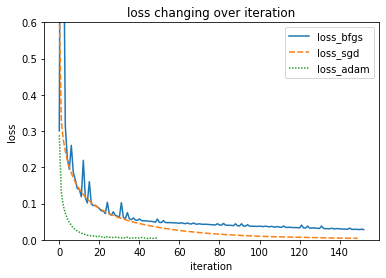

In [151]:
fig = plt.figure(1)
ax = plt.subplot(111)
res_bfgs = pd.DataFrame({'time':times, 'loss_bfgs':losses, 'iter':iters})
# g1 = sns.lineplot(x='time', y='loss', data=res_bfgs, label='a')
res_sgd = pd.DataFrame(pred_model_sgd.history.history)
res_adam = pd.DataFrame(pred_model_adam.history.history)
res_sgd = res_sgd.rename(columns={'loss':'loss_sgd'})
res_adam = res_adam.rename(columns={'loss':'loss_adam'})
print(res_sgd)
# g2 = sns.lineplot(x='time', y='loss', data=res_sgd)
g = sns.lineplot(data=[res_bfgs['loss_bfgs'], res_sgd['loss_sgd'], res_adam['loss_adam']])
g.set_title('loss changing over iteration')
g.set_ylim(0,0.6)
g.set_xlabel('iteration')
g.set_ylabel('loss')


            loss_sgd  accuracy
time                          
4.963413    0.640478  0.837850
9.160357    0.326727  0.909117
13.304656   0.276082  0.921467
17.466492   0.244681  0.930750
21.632833   0.220667  0.937600
...              ...       ...
628.622180  0.004389  0.999883
632.904240  0.004338  0.999900
637.174195  0.004260  0.999900
641.448274  0.004223  0.999883
645.726415  0.004144  0.999900

[150 rows x 2 columns]


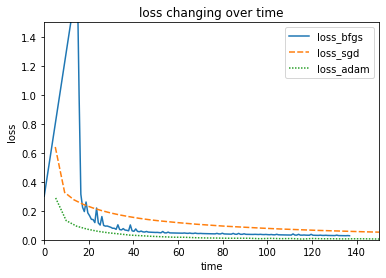

In [147]:
fig = plt.figure(1)
ax = plt.subplot(111)
res_bfgs = pd.DataFrame({'time':times, 'loss_bfgs':losses, 'iter':iters})
# g1 = sns.lineplot(x='time', y='loss', data=res_bfgs, label='a')
res_sgd = pd.DataFrame(pred_model_sgd.history.history)
res_adam = pd.DataFrame(pred_model_adam.history.history)
res_sgd = res_sgd.rename(columns={'loss':'loss_sgd'})
res_adam = res_adam.rename(columns={'loss':'loss_adam'})
res_bfgs = res_bfgs.set_index('time')
res_sgd = res_sgd.set_index('time')
res_adam = res_adam.set_index('time')
print(res_sgd)
# g2 = sns.lineplot(x='time', y='loss', data=res_sgd)
g = sns.lineplot(data=[res_bfgs['loss_bfgs'], res_sgd['loss_sgd'], res_adam['loss_adam']])
sns.ylabel = 'ss'
plt.title = 'loss over time'
ax.set(xlabel='time', ylabel='loss')
ax.set_title('loss changing over time')
plt.ylim(0,1.5)
plt.xlim(0,150)
fig.savefig('ss',dpi=500)
